In [ ]:
!ls -al /content/drive/MyDrive/NYCU_Intro2DL/midterm/
#!nvidia-smi

total 212468
-rw------- 1 root root     53595 May  6 04:16 0716085.ipynb
-rw------- 1 root root      1635 Mar 30 07:33 example.ipynb
-rw------- 1 root root 217497600 Apr 18 03:46 image.csv
-rw------- 1 root root      4663 Mar 30 07:33 label.csv
drwx------ 2 root root      4096 Apr 16 12:16 mymodel
drwx------ 2 root root      4096 Apr  8 06:47 photos


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, Lambda
from tensorflow.keras.layers import Multiply
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import time, os

base_path = "/content/drive/MyDrive/NYCU_Intro2DL/midterm/"
# gradeset: https://drive.google.com/drive/folders/1Qo7aQWCeqEmgRQ3pFRDIZWHbiQdIsxhz

In [ ]:
def RC_Net(Shape = (64, 64, 3)):
    inputs = Input(shape = Shape)
    reg = Lambda(lambda x: x / 255)(inputs) # regularization
    b1 = Conv2D(64, (8, 8), activation = "relu", padding = "valid")(reg)
    b1 = MaxPooling2D((3, 3), strides = (1, 1), padding = "valid")(b1)
    b1 = Conv2D(32, (5, 5), activation = "relu", padding = "valid")(b1)
    b1 = MaxPooling2D((3, 3), strides = (2, 1), padding = "valid")(b1)

    b2 = Conv2D(16, (3, 3), activation = "relu", padding = "valid")(b1)
    b2 = MaxPooling2D((3, 3), strides = (1, 1), padding = "valid")(b2)
    b2 = Conv2D(16, (3, 3), activation = "relu", padding = "valid")(b2)
    b2 = MaxPooling2D((3, 3), strides = (1, 1), padding = "valid")(b2)
    b2 = Conv2D(8, (3, 3), activation = "relu", padding = "valid")(b2)
    b2 = MaxPooling2D((3, 3), strides = (1, 1), padding = "valid")(b2)

    flat = Flatten()(b2)
    b3 = Dense(units = 64, activation = "relu")(flat)
    b3 = Dropout(rate = 0.5)(b3)
    b3 = Dense(units = 32, activation = "relu")(b3)
    b3 = Dropout(rate = 0.5)(b3)
    outputs = Dense(units = 3, activation = "relu")(b3)

    return Model(inputs = inputs, outputs = outputs, name = "RC-Net")

In [ ]:
""" Read Dataset """
if not os.path.isfile(base_path + "image.npy"):
    file_list = []
    for root, dirs, files in os.walk(base_path + "photos"):
        for file in files:
            filename = os.path.join(root, file)
            file_list.append(filename)
    file_list.sort()
    img_list = []
    size = (128, 128)
    for i in range(len(file_list)):
        im = Image.open(file_list[i])
        im = im.resize(size, Image.BILINEAR)
        imarray = np.array(im)
        img_list.append(imarray)
    x = np.asarray(img_list)
    np.save(base_path + "image.npy", x)
else:
    x = np.load(base_path + "image.npy")
y = pd.read_csv(base_path + "label.csv", encoding = 'big5')
y = y.drop(columns = "file name").values

print(x.shape, y.shape)

(177, 128, 128, 3) (177, 3)


In [ ]:
""" Data Augmentation: sampling in dataset, and do some proc to img """ 
x_set = x
y_set = y / [100.0, 1000.0, 1000.0] # regularization to label
x_train, y_train = x_set, y_set
# 90 degree
x_tmp, x_part, y_tmp, y_part = train_test_split(x_set, y_set, test_size = 0.15)
for i in range(x_part.shape[0]):
	x_part[i] = np.rot90(x_part[i], k = 1)
x_train = np.append(x_train, x_part, axis = 0)
y_train = np.append(y_train, y_part, axis = 0)
# 180 degree
x_tmp, x_part, y_tmp, y_part = train_test_split(x_set, y_set, test_size = 0.15)
for i in range(x_part.shape[0]):
	x_part[i] = np.rot90(x_part[i], k = 2)
x_train = np.append(x_train, x_part, axis = 0)
y_train = np.append(y_train, y_part, axis = 0)
# 270 degree
x_tmp, x_part, y_tmp, y_part = train_test_split(x_set, y_set, test_size = 0.15)
for i in range(x_part.shape[0]):
	x_part[i] = np.rot90(x_part[i], k = 3)
x_train = np.append(x_train, x_part, axis = 0)
y_train = np.append(y_train, y_part, axis = 0)
# lr flip
x_tmp, x_part, y_tmp, y_part = train_test_split(x_set, y_set, test_size = 0.15)
for i in range(x_part.shape[0]):
	x_part[i] = np.flip(x_part[i], axis = 1)
x_train = np.append(x_train, x_part, axis = 0)
y_train = np.append(y_train, y_part, axis = 0)
# up flip
x_tmp, x_part, y_tmp, y_part = train_test_split(x_set, y_set, test_size = 0.15)
for i in range(x_part.shape[0]):
	x_part[i] = np.flip(x_part[i], axis = 0)
x_train = np.append(x_train, x_part, axis = 0)
y_train = np.append(y_train, y_part, axis = 0)
print(x_train.shape, y_train.shape)

(312, 128, 128, 3) (312, 3)


In [ ]:
""" Train, Test Split """
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(249, 128, 128, 3) (249, 3)
(63, 128, 128, 3) (63, 3)


In [ ]:
model = RC_Net(Shape = (128, 128, 3))
model.summary()
model.compile(loss = MeanAbsoluteError(), optimizer = Adam(lr = 0.001), metrics = ["acc"])

Model: "RC-Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 121, 121, 64)      12352     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 119, 119, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 115, 115, 32)      51232     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 57, 113, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 55, 111, 16)       4624 

In [ ]:
history = model.fit(x_train, y_train, batch_size = 32, epochs = 50, 
    shuffle = True, validation_data = (x_test, y_test))

8/8 [==============================] - 0s 25ms/step - loss: 0.5465 - acc: 0.8835
Train Acc: 0.8835341334342957	Train Loss: 0.5465059280395508
2/2 [==============================] - 0s 23ms/step - loss: 0.5231 - acc: 0.8571
Test Acc: 0.8571428656578064	Train Loss: 0.5231279134750366


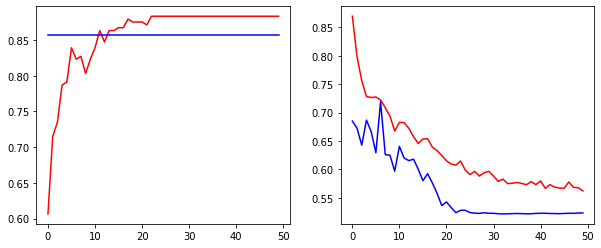

In [ ]:
result_train = model.evaluate(x_train, y_train)
print(f"Train Acc: {result_train[1]}\tTrain Loss: {result_train[0]}")
result_test = model.evaluate(x_test, y_test)
print(f"Test Acc: {result_test[1]}\tTrain Loss: {result_test[0]}")

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["acc"], color = "red")
plt.plot(history.history["val_acc"], color = "blue")
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], color = "red")
plt.plot(history.history["val_loss"], color = "blue")
plt.show()

In [ ]:
model.save(base_path + f"mymodel/0716085_front.h5py")

In [ ]:
""" Revise the effect of label's regularization """
def RC_Net_T(Shape = (64, 64, 1)):
    front_model = load_model(base_path + "mymodel/0716085_front.h5py")
    front_model.trainable = False
    inputs = Input(shape = Shape)
    block = front_model(inputs, training = False)
    block = Dense(units = 2048, activation = "relu")(block)
    block = Dropout(rate = 0.5)(block)
    block = Dense(units = 2048, activation = "relu")(block)
    block = Dropout(rate = 0.5)(block)
    outputs = Dense(units = 3, activation = "relu")(block)
    return Model(inputs = inputs, outputs = outputs, name = "RC-Net_2steps")

model_t = RC_Net_T(Shape = (128, 128, 3))
model_t.summary()
model_t.compile(loss = MeanAbsoluteError(), optimizer = Adam(lr = 0.001), metrics = ["acc"])
history = model_t.fit(x, y, batch_size = 32, epochs = 50)

6/6 [==============================] - 0s 25ms/step - loss: 461.0605 - acc: 0.8701
Acc: 0.8700565099716187	Loss: 461.0605163574219


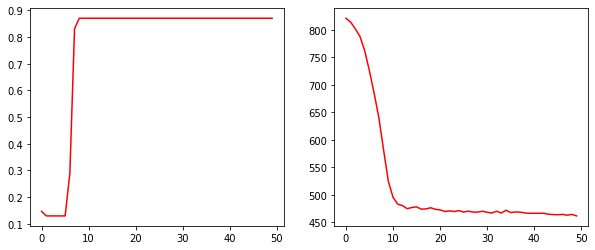

In [ ]:
eva = model_t.evaluate(x, y)
print(f"Acc: {eva[1]}\tLoss: {eva[0]}")
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["acc"], color = "red")
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], color = "red")
plt.show()

In [ ]:
pred = model_t.predict(x)
for k in range(pred.shape[0]):
    print(f"{pred[k]}  {y[k]}")

In [ ]:
model_t.save(base_path + "mymodel/0716085.h5py")

In [ ]:
""" double check """
mymodel = load_model(base_path + "mymodel/0716085.h5py")
eva = mymodel.evaluate(x, y)
print(f"Acc: {eva[1]}\tLoss: {eva[0]}")
pred = mymodel.predict(x)
for k in range(pred.shape[0]):
    print(f"{pred[k]}  {y[k]}")